FIGURE 1: OVERALL AVERAGE PROFILE


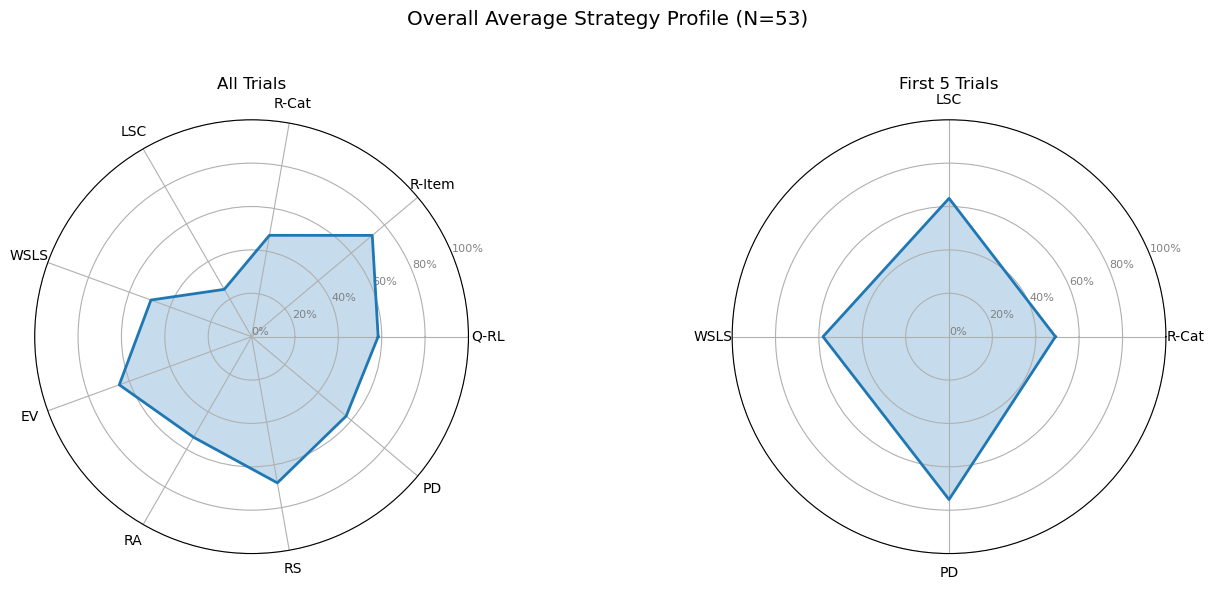

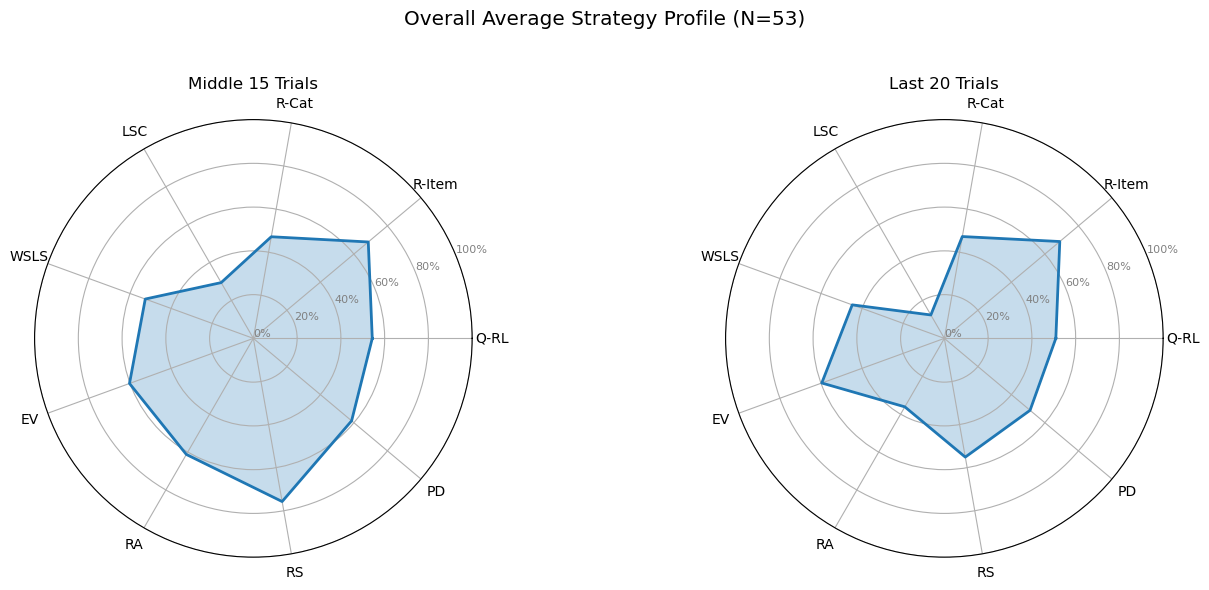


OPTIMAL K DETERMINATION
Optimal K = 2, Silhouette Score = 0.4170

 K  Silhouette_Score
 2          0.416996
 3          0.248222
 4          0.170863
 5          0.202204
 6          0.164789
 7          0.171187

FIGURE 2: GMM CLUSTERING


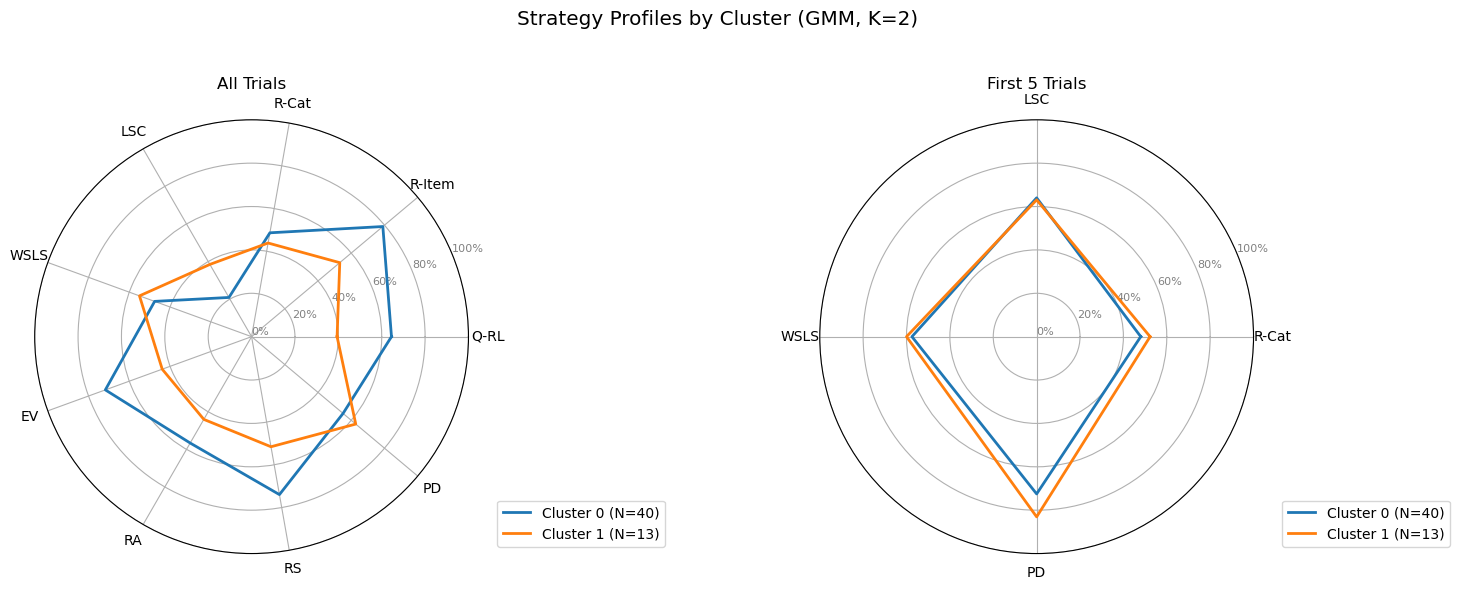

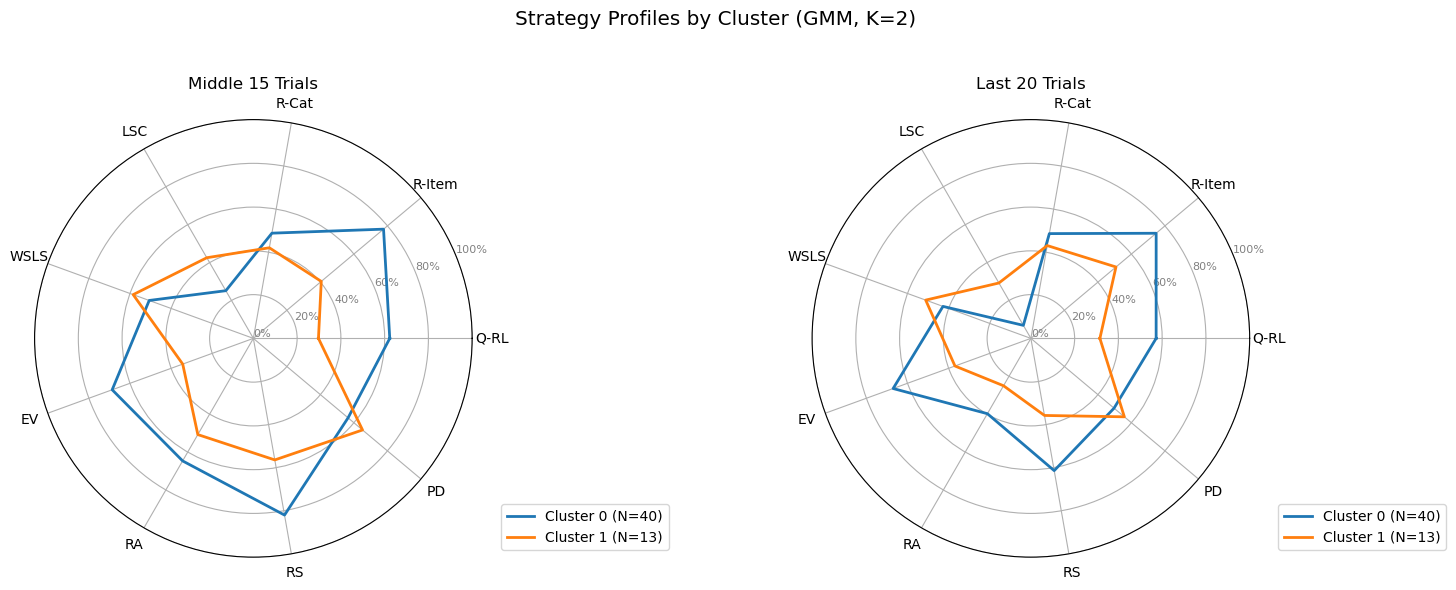


BETWEEN-CLUSTER COMPARISON (K=2)

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant

ALL:
  Q-RL    : p=0.0000 ***  |  C0>C1  |  d=+3.288
  R-Item  : p=0.0000 ***  |  C0>C1  |  d=+3.547
  R-Cat   : p=0.0290 *    |  C0>C1  |  d=+0.499
  LSC     : p=0.0000 ***  |  C0<C1  |  d=-1.832
  WSLS    : p=0.0087 **   |  C0<C1  |  d=-0.871
  EV      : p=0.0000 ***  |  C0>C1  |  d=+3.503
  RA      : p=0.0000 ***  |  C0>C1  |  d=+2.118
  RS      : p=0.0000 ***  |  C0>C1  |  d=+2.602

MID15:
  Q-RL    : p=0.0000 ***  |  C0>C1  |  d=+2.331
  R-Item  : p=0.0000 ***  |  C0>C1  |  d=+2.683
  R-Cat   : p=0.0162 *    |  C0>C1  |  d=+0.586
  LSC     : p=0.0175 *    |  C0<C1  |  d=-0.985
  EV      : p=0.0000 ***  |  C0>C1  |  d=+2.392
  RA      : p=0.0001 ***  |  C0>C1  |  d=+1.592
  RS      : p=0.0000 ***  |  C0>C1  |  d=+2.241

LAST20:
  Q-RL    : p=0.0000 ***  |  C0>C1  |  d=+2.283
  R-Item  : p=0.0000 ***  |  C0>C1  |  d=+2.528
  LSC     : p=0.0000 ***  |  C0<C1  |  d=-2.083
  WSLS    :

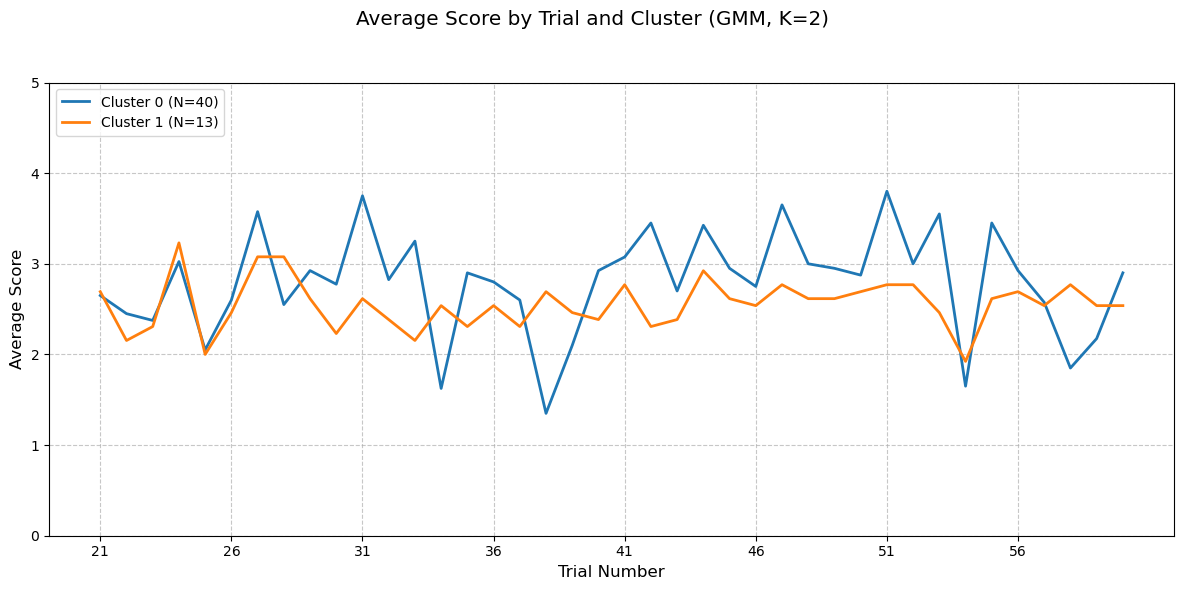

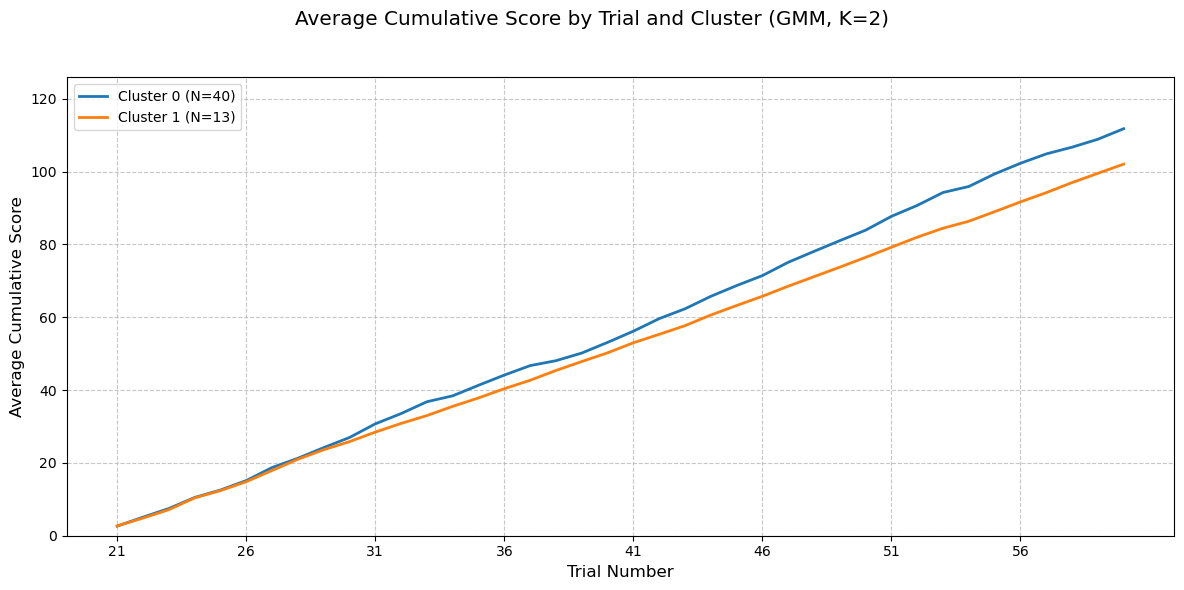


ANALYSIS COMPLETE


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.stats import friedmanchisquare
from itertools import combinations
import warnings

plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titleweight'] = 'normal'

warnings.filterwarnings("ignore")

# Configuration
STRATEGIES_ORDER = ["Q-RL", "R-Item", "R-Cat", "LSC", "WSLS", "EV", "RA", "RS", "PD"]
SUFFIXES = ["all", "first5", "mid15", "last20"]
K_RANGE = range(2, 8)
TO_REMOVE_FIRST5 = {"EV", "RA", "RS", "Q-RL", "R-Item"}
STRATEGIES_FIRST5 = [s for s in STRATEGIES_ORDER if s not in TO_REMOVE_FIRST5]
ALPHA = 0.05

# Data Loading
def load_and_preprocess(filepath="strategy_scores.csv"):
    df = pd.read_csv(filepath, index_col="participant_id")
    percent_cols = df.columns
    
    for col in percent_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace("%", "", regex=False).astype(float) / 100.0
        else:
            if df[col].max() > 1.0:
                df[col] = df[col] / 100.0
    
    return df

# Optimal K Determination
def find_optimal_k_gmm(df, suffix='all'):
    clustering_cols = [f"{s}_{suffix}" for s in STRATEGIES_ORDER]
    X = df[clustering_cols]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    best_score = -1
    best_k = K_RANGE.start
    results = []
    
    for k in K_RANGE:
        if k >= len(df):
            break
        
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
        cluster_labels = gmm.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, cluster_labels)
        
        results.append({'K': k, 'Silhouette_Score': score})
        
        if score > best_score:
            best_score = score
            best_k = k
    
    print(f"Optimal K = {best_k}, Silhouette Score = {best_score:.4f}\n")
    print(pd.DataFrame(results).to_string(index=False))
    
    return best_k, best_score

# GMM Clustering
def cluster_participants_gmm(df, k, clustering_suffix='all'):
    clustering_cols = [f"{s}_{clustering_suffix}" for s in STRATEGIES_ORDER]
    X = df[clustering_cols]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    cluster_labels = gmm.fit_predict(X_scaled)
    
    df['cluster_label'] = cluster_labels
    cluster_means = df.groupby('cluster_label').mean()
    
    return cluster_means, df['cluster_label']

# Radar Plot Helper Functions
def get_radar_data(data_row, suffix):
    if suffix == "first5":
        strategies = STRATEGIES_FIRST5
        cols = [f"{st}_{suffix}" for st in strategies]
    else:
        strategies = STRATEGIES_ORDER
        cols = [f"{st}_{suffix}" for st in strategies]
    
    values = data_row[cols].tolist()
    angles = np.linspace(0, 2 * np.pi, len(strategies), endpoint=False).tolist()
    values = values + values[:1]
    angles = angles + angles[:1]
    
    return values, angles, strategies

def setup_radar_plot(ax, values, angles, strategies, title, color, linestyle='-', linewidth=2, fill=True, label=None):
    ax.plot(angles, values, color=color, linewidth=linewidth, linestyle=linestyle, label=label)
    
    if fill:
        ax.fill(angles, values, color=color, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(strategies, fontsize=10)
    ax.set_ylim(0, 1.0)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_yticklabels([f'{int(y*100)}%' for y in ax.get_yticks()], color="grey", size=8)
    
    if fill:
        ax.set_title(title, size=12, color='black', pad=20, ha='center', va='bottom')

# Figure 1: Overall Average Profile
def plot_overall_average(df_mean):
    titles = ["All Trials", "First 5 Trials", "Middle 15 Trials", "Last 20 Trials"]
    colors = ['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4']
    
    fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(polar=True))
    fig1.suptitle('Overall Average Strategy Profile (N=53)')
    
    for i in range(2):
        values, angles, strategies = get_radar_data(df_mean.iloc[0], SUFFIXES[i])
        setup_radar_plot(axes1[i], values, angles, strategies, titles[i], colors[i], fill=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(polar=True))
    fig2.suptitle('Overall Average Strategy Profile (N=53)')
    
    for i in range(2):
        values, angles, strategies = get_radar_data(df_mean.iloc[0], SUFFIXES[i+2])
        setup_radar_plot(axes2[i], values, angles, strategies, titles[i+2], colors[i+2], fill=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Figure 2: Cluster Profiles
def plot_cluster_averages(cluster_means, k_used):
    cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b'][:k_used]
    titles = ["All Trials", "First 5 Trials", "Middle 15 Trials", "Last 20 Trials"]
    
    fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(polar=True))
    fig1.suptitle(f'Strategy Profiles by Cluster (GMM, K={k_used})')
    
    for i in range(2):
        ax = axes1[i]
        suf = SUFFIXES[i]
        title = titles[i]
        ax.set_title(title, size=12, color='black', pad=20, ha='center', va='bottom')
        
        first_cluster = True
        for cluster_id in range(k_used):
            cluster_row = cluster_means.loc[cluster_id]
            values, angles, strategies = get_radar_data(cluster_row, suf)
            label = f"Cluster {cluster_id} (N={cluster_means['participant_count'][cluster_id]:.0f})"
            setup_radar_plot(ax, values, angles, strategies, title, color=cluster_colors[cluster_id], 
                           linestyle='-', linewidth=2, fill=False, label=label)
            
            if first_cluster:
                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(strategies, fontsize=10)
                ax.set_ylim(0, 1.0)
                first_cluster = False
        
        ax.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0), fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(polar=True))
    fig2.suptitle(f'Strategy Profiles by Cluster (GMM, K={k_used})')
    
    for i in range(2):
        ax = axes2[i]
        suf = SUFFIXES[i+2]
        title = titles[i+2]
        ax.set_title(title, size=12, color='black', pad=20, ha='center', va='bottom')
        
        first_cluster = True
        for cluster_id in range(k_used):
            cluster_row = cluster_means.loc[cluster_id]
            values, angles, strategies = get_radar_data(cluster_row, suf)
            label = f"Cluster {cluster_id} (N={cluster_means['participant_count'][cluster_id]:.0f})"
            setup_radar_plot(ax, values, angles, strategies, title, color=cluster_colors[cluster_id], 
                           linestyle='-', linewidth=2, fill=False, label=label)
            
            if first_cluster:
                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(strategies, fontsize=10)
                ax.set_ylim(0, 1.0)
                first_cluster = False
        
        ax.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0), fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Between-Cluster Comparison (K=2 only)
def between_cluster_comparison(df_stat, optimal_k):
    if optimal_k != 2:
        print(f"Between-cluster comparison only available for K=2 (current K={optimal_k})")
        return None
    
    print("\n" + "="*70)
    print("BETWEEN-CLUSTER COMPARISON (K=2)")
    print("="*70)
    
    trial_blocks = ['all', 'mid15', 'last20']
    results_summary = []
    
    for trial_block in trial_blocks:
        strategies = STRATEGIES_FIRST5 if trial_block == "first5" else STRATEGIES_ORDER
        cluster_0_data = df_stat[df_stat['cluster_label'] == 0]
        cluster_1_data = df_stat[df_stat['cluster_label'] == 1]
        
        for strategy in strategies:
            col_name = f"{strategy}_{trial_block}"
            group_0 = cluster_0_data[col_name].values
            group_1 = cluster_1_data[col_name].values
            
            mean_0 = np.mean(group_0)
            mean_1 = np.mean(group_1)
            std_0 = np.std(group_0, ddof=1)
            std_1 = np.std(group_1, ddof=1)
            
            if len(group_0) >= 3 and len(group_1) >= 3:
                _, p_norm_0 = stats.shapiro(group_0)
                _, p_norm_1 = stats.shapiro(group_1)
                both_normal = (p_norm_0 > 0.05) and (p_norm_1 > 0.05)
            else:
                both_normal = True
            
            t_stat, p_ttest = stats.ttest_ind(group_0, group_1)
            u_stat, p_mann = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')
            
            pooled_std = np.sqrt(((len(group_0)-1)*std_0**2 + (len(group_1)-1)*std_1**2) / (len(group_0)+len(group_1)-2))
            cohens_d = (mean_0 - mean_1) / pooled_std if pooled_std > 0 else 0
            
            recommended_p = p_ttest if both_normal else p_mann
            sig = "***" if recommended_p < 0.001 else "**" if recommended_p < 0.01 else "*" if recommended_p < 0.05 else "ns"
            
            results_summary.append({
                'Trial_Block': trial_block,
                'Strategy': strategy,
                'C0_Mean': mean_0,
                'C1_Mean': mean_1,
                'p_value': recommended_p,
                'Sig': sig,
                'Cohen_d': cohens_d
            })
    
    df_results = pd.DataFrame(results_summary)
    
    print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant\n")
    
    for trial_block in trial_blocks:
        block_results = df_results[df_results['Trial_Block'] == trial_block]
        significant = block_results[block_results['Sig'] != 'ns']
        
        print(f"{trial_block.upper()}:")
        if len(significant) > 0:
            for _, row in significant.iterrows():
                direction = "C0>C1" if row['C0_Mean'] > row['C1_Mean'] else "C0<C1"
                print(f"  {row['Strategy']:8s}: p={row['p_value']:.4f} {row['Sig']:3s}  |  {direction}  |  d={row['Cohen_d']:+.3f}")
        else:
            print("  No significant differences")
        print()
    
    return df_results

# Within-Cluster Dominance Analysis
def within_cluster_dominance(df_stat, optimal_k):
    print("\n" + "="*70)
    print("WITHIN-CLUSTER DOMINANCE ANALYSIS")
    print("="*70)
    
    trial_blocks = ['all', 'mid15', 'last20']
    all_results = []
    
    for cluster_id in range(optimal_k):
        cluster_data = df_stat[df_stat['cluster_label'] == cluster_id]
        n_participants = len(cluster_data)
        
        if n_participants < 3:
            continue
        
        for trial_block in trial_blocks:
            strategies = STRATEGIES_FIRST5 if trial_block == "first5" else STRATEGIES_ORDER
            n_strategies = len(strategies)
            
            strategy_cols = [f"{s}_{trial_block}" for s in strategies]
            strategy_data = cluster_data[strategy_cols].values
            means = np.mean(strategy_data, axis=0)
            
            friedman_stat, friedman_p = friedmanchisquare(*strategy_data.T)
            proceed_to_posthoc = friedman_p < ALPHA
            
            dominant_strategies = []
            
            if proceed_to_posthoc:
                n_comparisons = n_strategies * (n_strategies - 1) // 2
                bonferroni_alpha = ALPHA / n_comparisons
                strategy_wins = {s: 0 for s in strategies}
                
                for i, j in combinations(range(n_strategies), 2):
                    data_i = strategy_data[:, i]
                    data_j = strategy_data[:, j]
                    
                    if np.all(data_i == data_j):
                        wilcoxon_p = 1.0
                    else:
                        _, wilcoxon_p = stats.wilcoxon(data_i, data_j, alternative='two-sided')
                    
                    if wilcoxon_p < bonferroni_alpha:
                        if means[i] > means[j]:
                            strategy_wins[strategies[i]] += 1
                        else:
                            strategy_wins[strategies[j]] += 1
                
                threshold = (n_strategies - 1) * 0.5
                
                for strat in strategies:
                    if strategy_wins[strat] >= threshold:
                        idx = strategies.index(strat)
                        dominant_strategies.append({
                            'Strategy': strat,
                            'Mean': means[idx],
                            'Wins': strategy_wins[strat]
                        })
            
            all_results.append({
                'Cluster': cluster_id,
                'Trial_Block': trial_block,
                'N': n_participants,
                'Friedman_p': friedman_p,
                'Significant': proceed_to_posthoc,
                'Dominant': ', '.join([d['Strategy'] for d in dominant_strategies]) if dominant_strategies else 'None'
            })
    
    df_within = pd.DataFrame(all_results)
    
    print("\nDominant strategies by cluster and trial block:\n")
    for cluster_id in range(optimal_k):
        cluster_results = df_within[df_within['Cluster'] == cluster_id]
        if len(cluster_results) > 0:
            print(f"Cluster {cluster_id}:")
            for _, row in cluster_results.iterrows():
                print(f"  {row['Trial_Block']:>8s}: {row['Dominant']}")
            print()
    
    return df_within

# Figure 3: Average Scores Over Trials
def plot_cluster_scores_over_trials(df_scores, cluster_labels, optimal_k):
    df_scores = df_scores.copy()
    df_scores['cluster_label'] = df_scores['participant_id'].map(cluster_labels)
    
    cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b'][:optimal_k]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Average Score by Trial and Cluster (GMM, K={optimal_k})')
    
    for cluster_id in range(optimal_k):
        cluster_data = df_scores[df_scores['cluster_label'] == cluster_id]
        if len(cluster_data) == 0:
            continue
        
        avg_scores = cluster_data.groupby('trial')['score'].mean().reset_index()
        ax.plot(avg_scores['trial'], avg_scores['score'], color=cluster_colors[cluster_id], 
                linewidth=2, label=f"Cluster {cluster_id} (N={len(cluster_data['participant_id'].unique())})")
    
    ax.set_xlabel('Trial Number', fontsize=12)
    ax.set_ylabel('Average Score', fontsize=12)
    ax.set_ylim(0, df_scores['score'].max() + 1)
    ax.set_xticks(range(21, 61, 5))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Figure 4: Cumulative Scores Over Trials
def plot_cluster_cumulative_scores_over_trials(df_scores, cluster_labels, optimal_k):
    df_scores = df_scores.copy()
    df_scores['cluster_label'] = df_scores['participant_id'].map(cluster_labels)
    df_scores['cumulative_score'] = df_scores.groupby('participant_id')['score'].cumsum()
    
    cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b'][:optimal_k]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Average Cumulative Score by Trial and Cluster (GMM, K={optimal_k})')
    
    for cluster_id in range(optimal_k):
        cluster_data = df_scores[df_scores['cluster_label'] == cluster_id]
        if len(cluster_data) == 0:
            continue
        
        avg_cum_scores = cluster_data.groupby('trial')['cumulative_score'].mean().reset_index()
        ax.plot(avg_cum_scores['trial'], avg_cum_scores['cumulative_score'], 
                color=cluster_colors[cluster_id], linewidth=2, 
                label=f"Cluster {cluster_id} (N={len(cluster_data['participant_id'].unique())})")
    
    ax.set_xlabel('Trial Number', fontsize=12)
    ax.set_ylabel('Average Cumulative Score', fontsize=12)
    ax.set_ylim(0, df_scores['cumulative_score'].max() + 1)
    ax.set_xticks(range(21, 61, 5))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Main Analysis Pipeline
df_all = load_and_preprocess()

# Figure 1
print("=" * 70)
print("FIGURE 1: OVERALL AVERAGE PROFILE")
print("=" * 70)
df_overall_mean = df_all.mean().to_frame().T
plot_overall_average(df_overall_mean)

# Optimal K determination
print("\n" + "=" * 70)
print("OPTIMAL K DETERMINATION")
print("=" * 70)
optimal_k, best_score = find_optimal_k_gmm(df_all.copy(), suffix='all')

# GMM Clustering
print("\n" + "=" * 70)
print("FIGURE 2: GMM CLUSTERING")
print("=" * 70)
cluster_means, cluster_labels = cluster_participants_gmm(df_all.copy(), optimal_k, 'all')

cluster_sizes = cluster_labels.value_counts().sort_index()
cluster_means['participant_count'] = cluster_sizes.reindex(cluster_means.index, fill_value=0)

plot_cluster_averages(cluster_means, optimal_k)

# Statistical Analysis
df_stat = df_all.copy()
df_stat['cluster_label'] = cluster_labels

between_results = between_cluster_comparison(df_stat, optimal_k)
within_results = within_cluster_dominance(df_stat, optimal_k)

# Load decision scores and plot
df_scores = pd.read_csv("decision.csv", header=None, names=['participant_id', 'trial', 'choice', 'score'])

print("\n" + "=" * 70)
print("FIGURES 3 & 4: PERFORMANCE OVER TRIALS")
print("=" * 70)

plot_cluster_scores_over_trials(df_scores, cluster_labels, optimal_k)
plot_cluster_cumulative_scores_over_trials(df_scores, cluster_labels, optimal_k)

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)